***
<p style="font-size:26px;">
<font color=red> Machine Learning Algorithms For Prediction</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle Cloud Infrastructure</font></p>

***

## Overview:
This notebook provides a few algorith for classification. 


We demonstrate simple steps for training models and deploying it to production. Two approaches are demonstared:
1. regression: available data up until the race are used for regressing `StintLen` when `stintNumber==1`
2. classification: available data up until the race and normalzied `stintLen` from past events are used. In this case we bucketized `StintLen` (5 buckets) and label of buckets are served as `class label`

---

## Contents:

* <a href='#intro'>Introduction</a>



---

### Load basic packages

In [1]:
path = '/home/datascience/WorkSpace/RedBull-Racining-TimeToPit/notebooks'
data_path = '../data/'

In [2]:
import os
os.chdir(path)
import pandas as pd
import logging
import json
import pickle
import requests
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

<a id='intro'></a>
## Introduction
abc


In [3]:
df = pd.read_csv(data_path+'final_data.csv',)

## remove any StintLen lesser than 5 and greather than 50
df = df[(df['StintLen']>5) & (df['StintLen']<50)]

## bucketize `target variable` and assign a label to each bucket
bins = np.array([1,15,25,30,35,150])
labels = np.arange(len(bins)-1)
df['classLabels'] = pd.cut(df.StintLen, bins=bins,labels=labels)

print('-'*80, '\n', 'Size of Data: ', df.shape,'\n', '-'*80,'\n')

## remove all nan rows as some of algoritms are not freindly with nan
df = df[~df['TyreAge'].isna()]

print('-'*80, '\n', 'Size of Data after remving NaNs: ', df.shape,'\n', '-'*80,'\n')
df.head(2)

-------------------------------------------------------------------------------- 
 Size of Data:  (3033, 21) 
 -------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 
 Size of Data after remving NaNs:  (2945, 21) 
 -------------------------------------------------------------------------------- 



,Unnamed: 0,EventName,RoundNumber,eventYear,Compound,Driver,Stint,bestPreRaceTime,bestLapTimeIsFrom,meanAirTemp,...,meanHumid,Rainfall,GridPosition,Position,raceStintsNums,TyreAge,StintLen,CircuitLength,designedLaps,classLabels
0,0,Abu Dhabi Grand Prix,17,2020,HARD,ALB,2.0,95.571,Qualifying,22.908889,...,58.248889,0.0,5.0,4.0,2.0,1.0,45.0,5.554,55,4
1,1,Abu Dhabi Grand Prix,17,2020,HARD,BOT,2.0,95.271,Qualifying,22.906667,...,58.237778,0.0,2.0,2.0,2.0,1.0,45.0,5.554,55,4


*** x  **************************************************************************************************** 



,meanAirTemp,meanTrackTemp,meanHumid,Rainfall,GridPosition,Position,StintLen
meanAirTemp,1.000000,0.578399,-0.317776,-0.158159,0.025325,0.019158,0.071098
meanTrackTemp,0.578399,1.000000,-0.435079,-0.164316,0.007678,0.017224,0.087148
meanHumid,-0.317776,-0.435079,1.000000,0.148734,-0.010838,0.002067,0.052114
Rainfall,-0.158159,-0.164316,0.148734,1.000000,0.020785,0.004746,-0.048155
GridPosition,0.025325,0.007678,-0.010838,0.020785,1.000000,0.635363,-0.011047
Position,0.019158,0.017224,0.002067,0.004746,0.635363,1.000000,-0.096630
StintLen,0.071098,0.087148,0.052114,-0.048155,-0.011047,-0.096630,1.000000


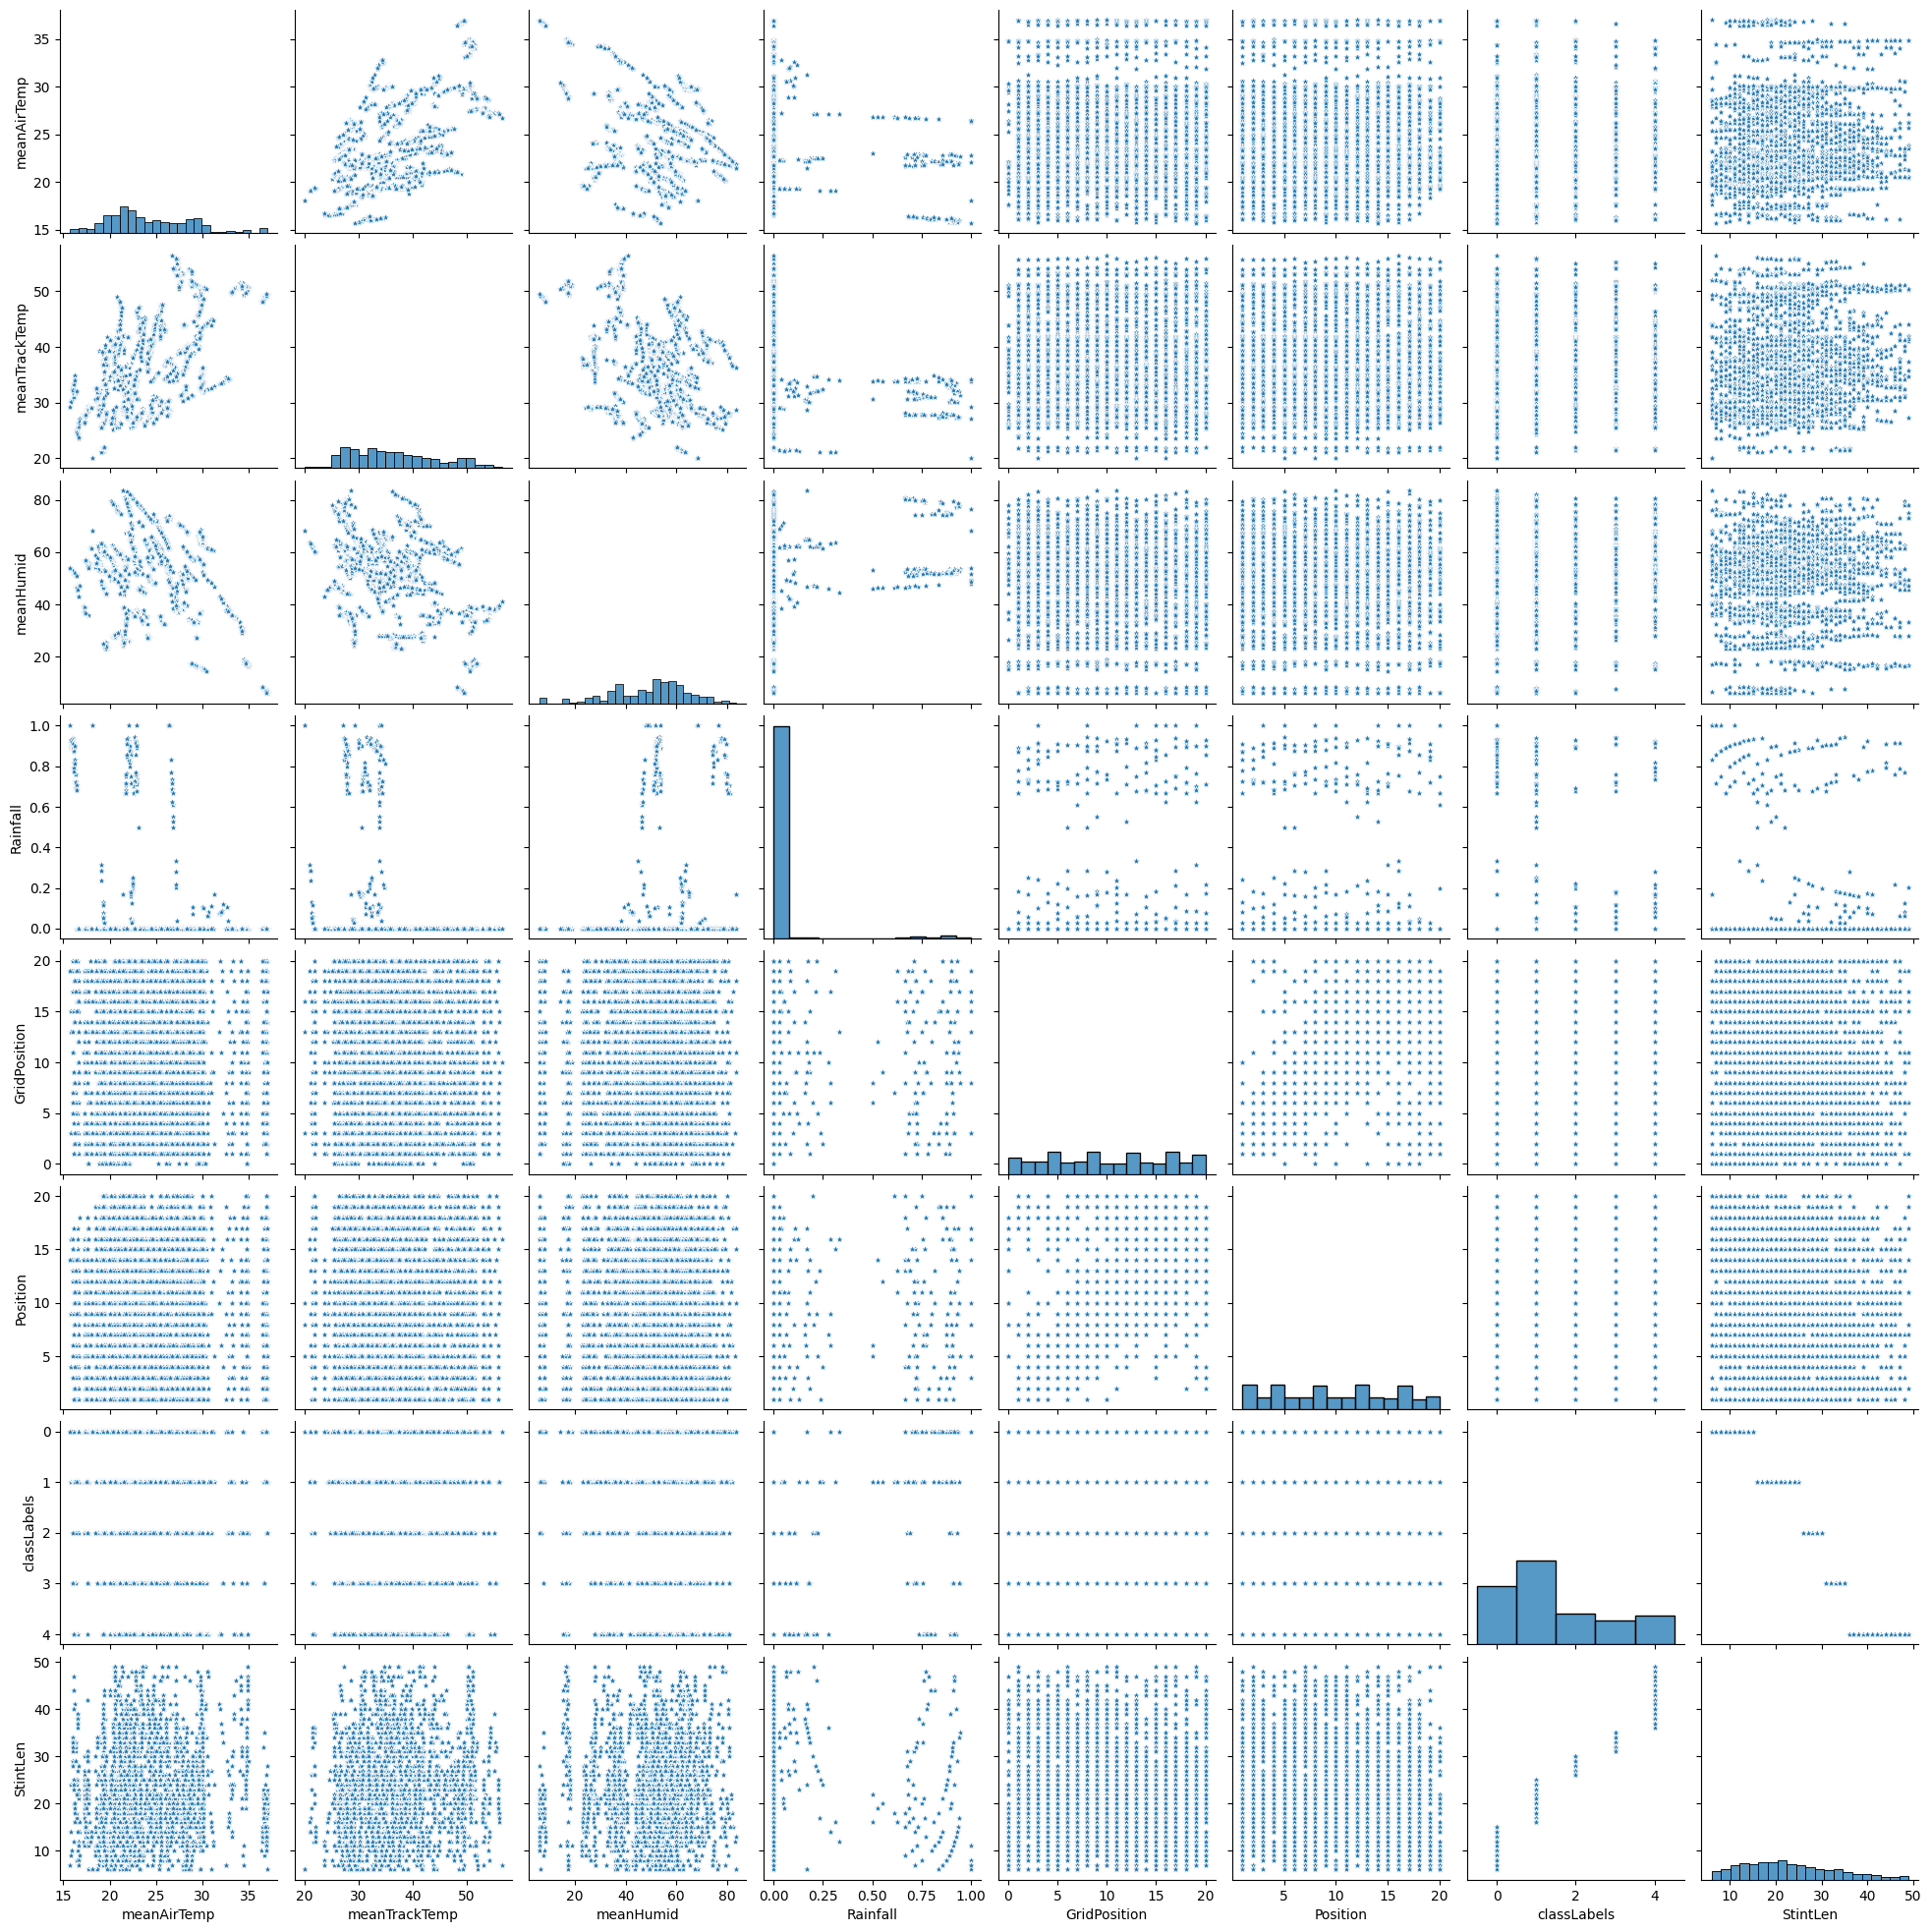

In [25]:
columns = ['meanAirTemp', 'meanTrackTemp', 'meanHumid', 'Rainfall', 
           'GridPosition', 'Position','classLabels','StintLen']#list(df.columns)[3:10]

x = df[columns].reset_index(drop=True)

# x['EventName'] = le.fit_transform(x['EventName'])
# x['Compound'] = le.fit_transform(x['Compound'])
# x['Driver'] = le.fit_transform(x['Driver'])

print('*** x  '+'*' * 100,"\n")
display(x[columns].corr())
sns.pairplot(x, vars= columns, palette = "Set1", markers='*') #,markers='*'
plt.show()

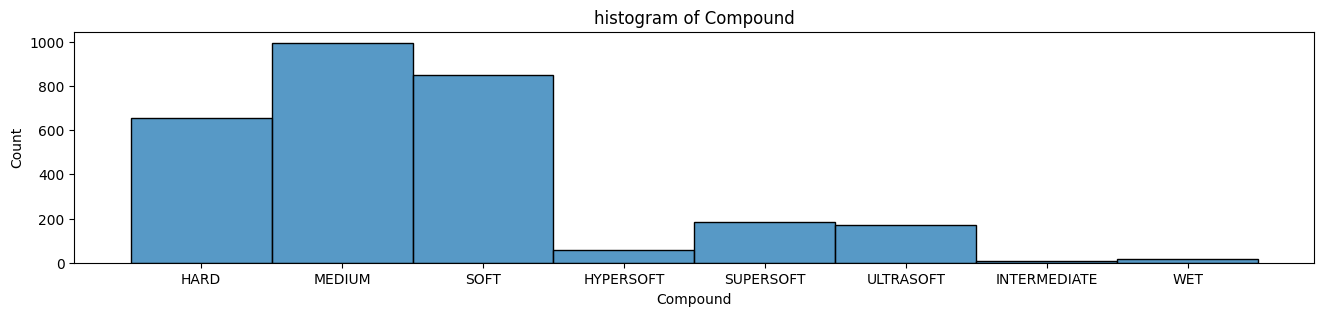

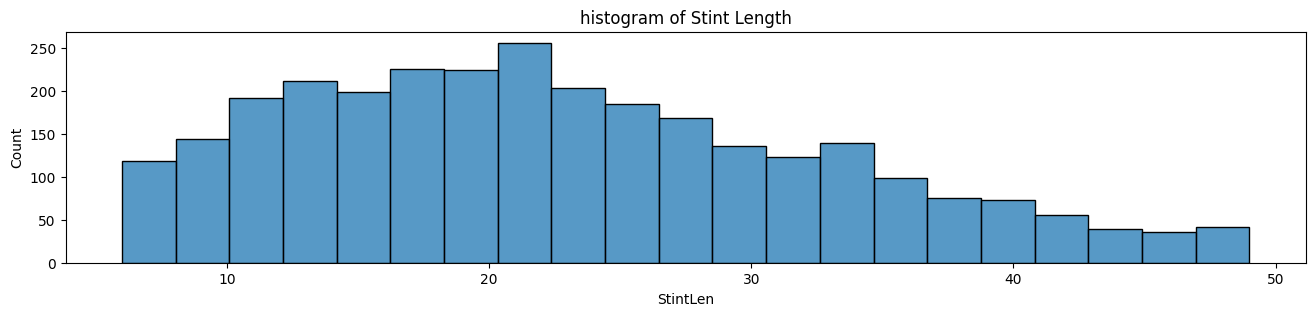

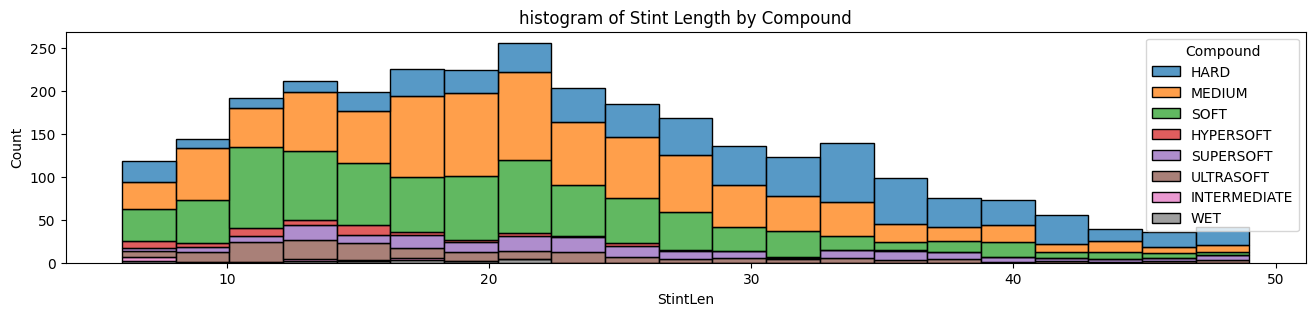

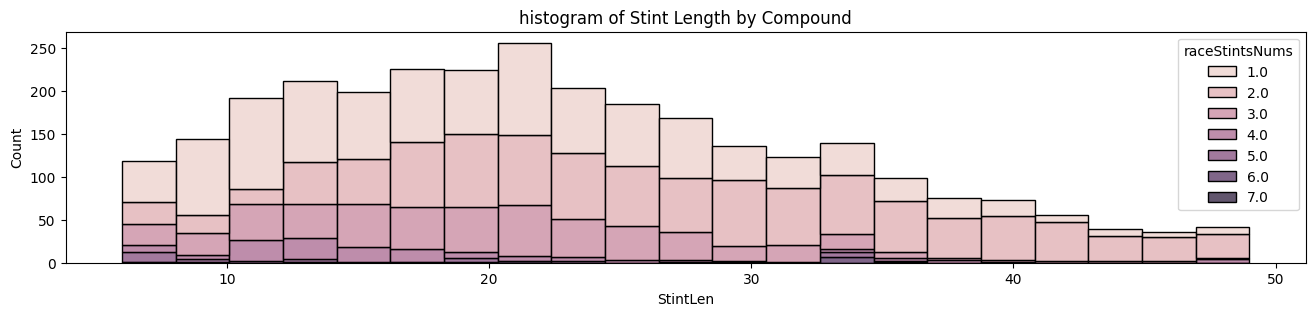

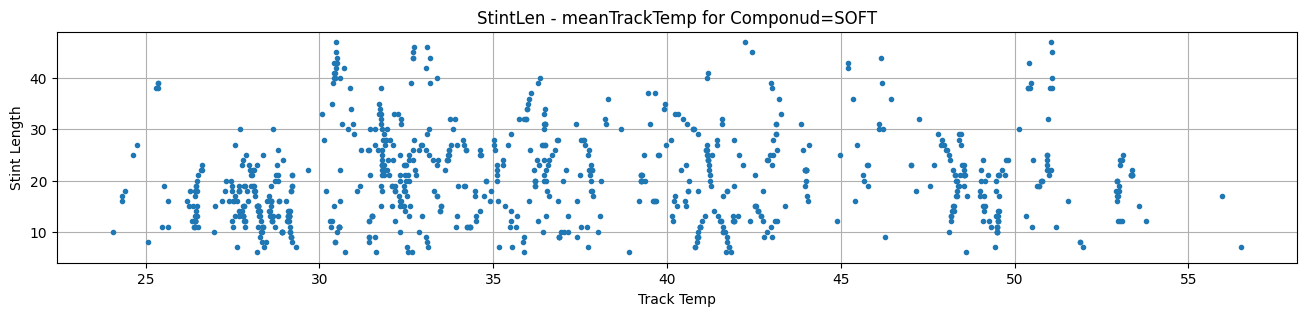

In [4]:
plt.figure(figsize=(16,3))
sns.histplot(data=df, x="Compound", multiple="stack")
plt.title('histogram of Compound')

plt.figure(figsize=(16,3))
sns.histplot(data=df, x="StintLen")
plt.title('histogram of Stint Length')

plt.figure(figsize=(16,3))
sns.histplot(data=df, x="StintLen", hue="Compound", multiple="stack")
plt.title('histogram of Stint Length by Compound')

plt.figure(figsize=(16,3))
sns.histplot(data=df, x="StintLen", hue="raceStintsNums", multiple="stack")
plt.title('histogram of Stint Length by Compound')

plt.figure(figsize=(16,3))
plt.plot(df['meanTrackTemp'][df['Compound']=='SOFT'],df['StintLen'][df['Compound']=='SOFT'],'.')
plt.grid()
plt.title('StintLen - meanTrackTemp for Componud=SOFT')
plt.xlabel('Track Temp')
plt.ylabel('Stint Length')

# sns.lineplot(data=df[df['Compound']=='SOFT'], x="meanTrackTemp", y="StintLen", hue="Compound")

# plt.figure(figsize=(16,3))
# sns.histplot(df, x='meanTrackTemp', y='StintLen', hue='Compound')


# x = df['meanTrackTemp'][df['Compound']=='SOFT']
# y = df['StintLen'][df['Compound']=='SOFT']
# ax = sns.regplot(x=x, y=y, color="g")

plt.show()

In [5]:
df.columns

Index(['Unnamed: 0', 'EventName', 'RoundNumber', 'eventYear', 'Compound',
       'Driver', 'Stint', 'bestPreRaceTime', 'bestLapTimeIsFrom',
       'meanAirTemp', 'meanTrackTemp', 'meanHumid', 'Rainfall', 'GridPosition',
       'Position', 'raceStintsNums', 'TyreAge', 'StintLen', 'CircuitLength',
       'designedLaps', 'classLabels'],
      dtype='object')

<a id='create'></a>
# Modeling

In [6]:
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
# from sklearn.preprocessing import LabelEncoder, OrdinalEncoder 
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
import lightgbm as lgbm
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [7]:
sc  = StandardScaler()
le = LabelEncoder()

x = df[['EventName','Compound','Driver','raceStintsNums','TyreAge',
           'meanAirTemp', 'meanTrackTemp', 'meanHumid', 'Rainfall', 
           'GridPosition', 'Position','CircuitLength','classLabels','StintLen']].reset_index(drop=True)

x['EventName'] = le.fit_transform(x['EventName'])
x['Compound'] = le.fit_transform(x['Compound'])
x['Driver'] = le.fit_transform(x['Driver'])


y_mc = x['classLabels']
x_mc = x.drop(['classLabels','StintLen','raceStintsNums'],axis=1) 

x_reg = x[x['raceStintsNums']==1]
y_reg = x_reg['StintLen']
x_reg = x_reg.drop(['classLabels','StintLen'], axis=1)

<a id='create_preprocess'></a>
## Train/test samples

In this section, you will preprocess the data. The categorical variables are encoded and missing values are imputed. These steps will be performed with a pipeline and the pipeline is used to transform the independent variables.

In [8]:
X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(x_mc, y_mc, test_size=0.25, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, y_reg, test_size=0.25, random_state=42)
print('Regression data size for train and test: ', len(X_train_reg), len(X_test_reg),'\nClassification data size for train and test: ', len(X_train_mc), len(y_test_mc))

Regression data size for train and test:  832 278 
Classification data size for train and test:  2208 737


<a id='create_preprocess1'></a>
## Regression based model: Only Stint 1


In [9]:
## checking lgbm

In [10]:
%%time
gbm = lgbm.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=12)
gbm.fit(X_train_reg, y_train_reg,
        eval_set=[(X_test_reg, y_test_reg)],
        eval_metric='l1',
        callbacks=[lgbm.early_stopping(5)])

print('\nStarting predicting...\n')
# predict
y_pred = gbm.predict(X_test_reg, num_iteration=gbm.best_iteration_)
rmse_test = mean_squared_error(y_test_reg, y_pred) ** 0.5
print(f'The RMSE of prediction is: {rmse_test}')

# feature importances
# print(f'Feature importances: {list(gbm.feature_importances_)}')

Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's l1: 5.77754	valid_0's l2: 53.0837

Starting predicting...

The RMSE of prediction is: 7.2858591372050325
CPU times: user 1min 46s, sys: 79.8 ms, total: 1min 46s
Wall time: 7.5 s


In [11]:
## predition vs actuall plot

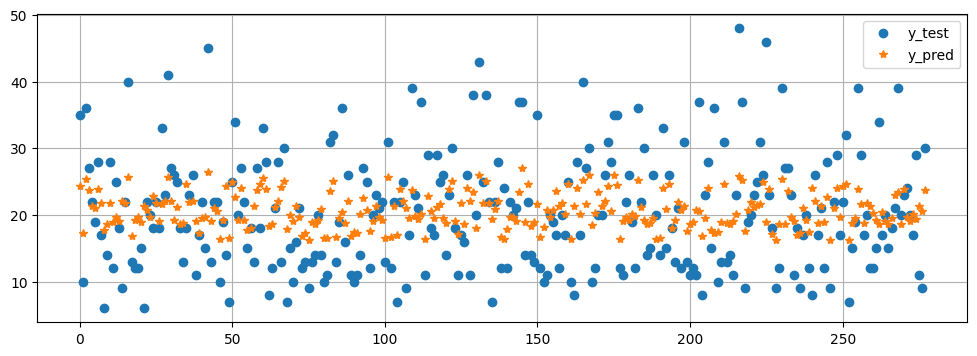

In [12]:
plt.figure(figsize=(12,4) )
plt.plot(range(len(y_pred)),y_test_reg,'o')
plt.plot(range(len(y_pred)),y_pred,'*')
plt.legend(['y_test','y_pred'])
plt.grid()
plt.show()

In [13]:
## lgbm: grid search

In [14]:
%%time
estimator = lgbm.LGBMRegressor()

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [6, 12]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(X_train_reg, y_train_reg)
cvResults = gbm.cv_results_

print(f'Best parameters found by grid search are: {gbm.best_params_}')

Best parameters found by grid search are: {'learning_rate': 0.1, 'n_estimators': 12}
CPU times: user 14min 50s, sys: 631 ms, total: 14min 51s
Wall time: 1min 2s


In [ ]:
#cross validation lgbm
x_lgbm = lgbm.Dataset(data = x_reg, label = y_reg, feature_name = list(x_reg))

lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    "learning_rate": 0.01,
#     "num_leaves": 180,
#     "feature_fraction": 0.50,
#     "bagging_fraction": 0.50,
#     'bagging_freq': 4,
#     "max_depth": -1,
    "reg_alpha": 0.3,
    "reg_lambda": 0.1,
    #"min_split_gain":0.2,
#     "min_child_weight":10,
#     'zero_as_missing':True
                }

# N_FOLDS = 3
# MAX_BOOST_ROUNDS = 50
# LEARNING_RATE = .02
# cv_results = lgbm.cv(lgbm_params, x_lgbm, num_boost_round=MAX_BOOST_ROUNDS, nfold=N_FOLDS, 
#                     verbose_eval=20, early_stopping_rounds=40)

<a id='compare_different_models'></a>
## Multiclass Modeling

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.svm import SVC

import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import get_scorer
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
from sklearn.metrics import classification_report

In [16]:
# prec, recall,clf.classes_, acc

In [17]:
%%time
model_accuracy = pd.DataFrame(columns=['Model','Test_Accuracy'])
model_rocs = pd.DataFrame(columns=['Model'])
models = {
          "LGBM" : LGBMClassifier(objective='binary', max_depth=5,),
          "DT" : DecisionTreeClassifier(max_depth=5),
          'GBC' : GradientBoostingClassifier(max_depth=5),
          'XGB' : XGBClassifier(max_depth=5),
          }

for test, clf in models.items():
    clf.fit(X_train_mc, y_train_mc)
    y_pred = clf.predict(X_test_mc)
    acc = accuracy_score(y_test_mc,y_pred)
    train_pred = clf.predict(X_train_mc)
    train_acc = accuracy_score(y_train_mc, train_pred)
    print("\n", test + ' scores')
    print(acc)
    print(classification_report(y_test_mc,y_pred))
    print(confusion_matrix(y_test_mc,y_pred))
    
    
#     fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=clf.classes_[1])
#     prec, recall, _ = precision_recall_curve(y_test, y_pred, pos_label=clf.classes_[1])
#     roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
#     pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
    
    model_accuracy = model_accuracy.append({'Model': test, 'Test_Accuracy': acc, 
                                            'Train_acc': train_acc,
#                                            'Prec': prec[1], 'Recall':recall[1],
#                                             'FPr': fpr[1], 'TPr': tpr[1],
                                           }, ignore_index=True)
#     if test!='NNet':
#         roc_display = RocCurveDisplay.from_estimator(clf, X_test, y_test)
#         model_rocs = model_rocs.append({'Model': roc_display})
        

#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    
#     roc_display.plot(ax=ax1)
#     pr_display.plot(ax=ax2)
#     plt.show()
    print('-' * 100,"\n")

model_accuracy.sort_values(ascending=False, by = 'Test_Accuracy')


 LGBM scores
0.6092265943012212
              precision    recall  f1-score   support

           0       0.68      0.64      0.66       192
           1       0.62      0.73      0.67       262
           2       0.49      0.34      0.40       103
           3       0.54      0.36      0.43        87
           4       0.59      0.74      0.66        93

    accuracy                           0.61       737
   macro avg       0.58      0.56      0.56       737
weighted avg       0.60      0.61      0.60       737

[[122  55   2   6   7]
 [ 46 192  10   5   9]
 [  6  38  35  12  12]
 [  3  17  16  31  20]
 [  3  10   8   3  69]]
---------------------------------------------------------------------------------------------------- 


 DT scores
0.45861601085481685
              precision    recall  f1-score   support

           0       0.69      0.37      0.48       192
           1       0.44      0.81      0.57       262
           2       0.67      0.02      0.04       103
          

/home/datascience/conda/generalml_p37_cpu_v1/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:46:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 XGB scores
0.6621438263229308
              precision    recall  f1-score   support

           0       0.76      0.68      0.71       192
           1       0.64      0.81      0.71       262
           2       0.55      0.41      0.47       103
           3       0.58      0.41      0.48        87
           4       0.72      0.74      0.73        93

    accuracy                           0.66       737
   macro avg       0.65      0.61      0.62       737
weighted avg       0.66      0.66      0.65       737

[[130  51   2   6   3]
 [ 34 211   7   2   8]
 [  3  38  42  11   9]
 [  3  21  20  36   7]
 [  2  10   5   7  69]]
---------------------------------------------------------------------------------------------------- 

CPU tim

,Model,Test_Accuracy,Train_acc
3,XGB,0.662144,0.993207
2,GBC,0.659430,0.971467
0,LGBM,0.609227,0.879076
1,DT,0.458616,0.499094


<a id='create_pipeline'></a>
## Create Pileline Model and Fit XGBClassifier

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from mlxtend.plotting import plot_confusion_matrix

In [64]:
# for i, col in x.iteritems():
#     if col.dtypes == "object":
#         categorical_cols.append(col.name)
#     else:
#         numerical_cols.append(col.name)

# for col in categorical_cols:
#      x[col] = x[col].astype('category')

In [71]:
x = df[['EventName','Compound','Driver', 'TyreAge', 
           'meanAirTemp', 'meanTrackTemp', 'meanHumid', 'Rainfall', 
           'GridPosition', 'Position','CircuitLength','classLabels'] ].reset_index(drop=True)
categorical_cols = []
numerical_cols = []


y = x['classLabels']
x = x.drop(['classLabels'],axis=1)

X_train_xgbc, X_test_xgbc, y_train_xgbc, y_test_xgbc = train_test_split(x, y, test_size=0.25, random_state=42)

## Label encode

# le = LabelEnacoder()

## Extract numerical columns and categorical columns


for i, col in X_train_xgbc.iteritems():
    if col.dtypes == "object":
        categorical_cols.append(col.name)
    else:
        numerical_cols.append(col.name)     


categorical_transformer = Pipeline(
    steps=[('encoder', OrdinalEncoder())]
)

numeric_transformer = Pipeline(
    steps=[ ("scaler", StandardScaler()),]
)


# Build a pipeline
preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_cols),
                 ("num", numeric_transformer, numerical_cols),]
)

xgb_classifier = XGBClassifier(learning_rate=0.05, max_depth=5, use_label_encoder=False,
                    scale_pos_weight=1.0, eval_metric='mlogloss')

ppl_model = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', xgb_classifier)
    ])

ppl_model.fit(X_train_xgbc, y_train_xgbc)

[20:24:32] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['EventName', 'Compound',
                                                   'Driver']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['TyreAge', 'meanAirTemp',
                                                   'meanTrackTemp', 'meanHumid',
                                                   'Rainfall', 'GridPosition',
                                                   'Position',
                                                   'CircuitLength'])])),
          

Once the best model has been determined, you use the `.predict()` method to make predictions on a subset of the test dataset. It accepts predictors, in the form of a `DataFrame` object, and returns predicted values.

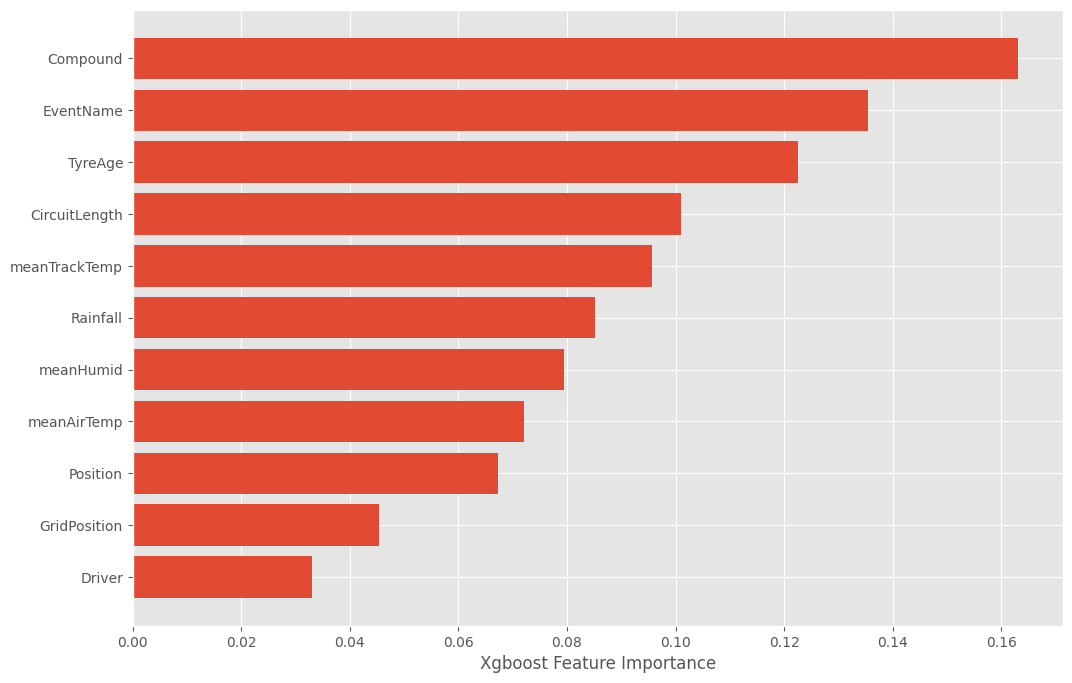

In [72]:
sorted_idx = xgb_classifier.feature_importances_.argsort()
fig = plt.figure(figsize=(12,8))
plt.barh(ppl_model.feature_names_in_[sorted_idx], xgb_classifier.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

In [73]:
def evaluator(y_test, y_pred):    
    # Accuracy:
    print('Accuracy is: ', accuracy_score(y_test,y_pred))
    print('')
    # Classification Report:
#     print('Classification Report: \n',classification_report(y_test,y_pred))

    print('Confusion Matrix: \n\n')
    plt.style.use("ggplot")
    cm = confusion_matrix(y_test,y_pred)
    plot_confusion_matrix(conf_mat = cm,figsize=(6,4),show_normed=True)
    plt.show()

In [74]:
y_pred_prob = ppl_model.predict_proba(X_test_xgbc)
y_pred_bin = ppl_model.predict(X_test_xgbc)
print(y_pred_bin[0:10])
print(y_pred_prob[0:10])

[1 1 1 1 0 1 1 1 1 1]
[[0.11975538 0.30224606 0.16773435 0.17288572 0.23737852]
 [0.10367532 0.6211443  0.20167969 0.03377839 0.03972226]
 [0.1135968  0.35570773 0.09532074 0.3400746  0.09530011]
 [0.15868959 0.57640344 0.21008055 0.0352469  0.0195795 ]
 [0.38019377 0.3634386  0.20327203 0.0262876  0.026808  ]
 [0.14985324 0.6558865  0.1516494  0.02155158 0.0210593 ]
 [0.15044487 0.5916637  0.2150311  0.02326898 0.01959131]
 [0.33358926 0.59274715 0.04173526 0.01715468 0.01477366]
 [0.33560193 0.37065357 0.12477512 0.08195332 0.0870161 ]
 [0.33022976 0.4791428  0.07122838 0.05253153 0.06686753]]


Test Accuracy
Accuracy is:  0.592944369063772

Confusion Matrix: 




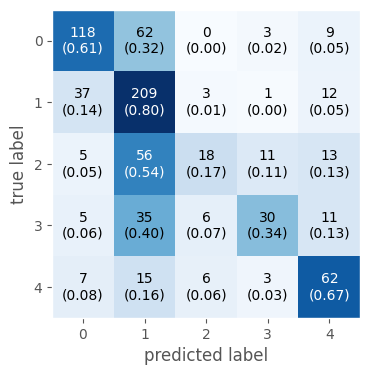

In [76]:
print("Test Accuracy")
evaluator(y_test_xgbc, y_pred_bin)

<a id='serialize'></a>
# Sklearn Framework Serialization

The Sklearn framework makes it easy to deploy a scikit-learn model into production. The `SklearnModel()` constructor takes a scikit-learn model and converts it into an `SklearnModel` object. To deploy the model into production, you need to prepare the model artifact, verify that the artifact works, save the model to the model catalog, and then deploy it.

ADS provides a number of methods that greatly simplify the model deployment process. It also provides the `.summary_status()` method that outputs a dataframe that defines the steps, status, and detailed information about each step. 

<a id='serialize_sklearnmodel'></a>
## Create a SklearnModel

The `SklearnModel()` constructor takes a scikit-learn model along with the path that you want to use to store the model artifacts. An `SklearnModel` object is returned, and it is used to manage the deployment.

The next cell creates a model artifact directory. This directory is used to store the artifacts that are needed to deploy the model. It also creates the `SklearnModel` object.

In [81]:
pwd

'/home/datascience/WorkSpace/RedBull-Racining-TimeToPit/notebooks'

In [77]:
from ads.catalog.model import ModelCatalog
from ads.common.model_metadata import UseCaseType
from ads.model.framework.sklearn_model import SklearnModel

In [82]:
artifact_dir = f"../md-rbc-XGBC-Pipeline-model"#tempfile.mkdtemp()
print(f"Model artifact director: {artifact_dir}")
sklearn_model = SklearnModel(estimator=ppl_model, artifact_dir=artifact_dir)

Model artifact director: ../md-rbc-XGBC-Pipeline-model


The `.summary_status()` method of the `SklearnModel` class is a handy method to keep track of the progress that you are making in deploying the model. It creates a dataframe that lists the deployment steps, thier status, and details about them. The next cell returns the summary status dataframe. It shows that the initiate step has been completed.

In [87]:
sklearn_model.summary_status()

<a id='serialize_prepare'></a>
## Prepare

The prepare step is performed by the `.prepare()` method of the `SklearnModel` class. It creates a number of customized files that are used to run the model once it is deployed. These include:

* `input_schema.json`: A JSON file that defines the nature of the features of the `X_sample` data. It includes metadata such as the data type, name, constraints, summary statistics, feature type, and more.
* `model.joblib`: This is the default filename of the serialized model. It can be changed with the `model_file_name` attribute. By default, the model is stored in a joblib file. The parameter `as_onnx` can be used to save it in the ONNX format.
* `output_schema.json`: A JSON file that defines the nature of the dependent variable in the `y_sample` data. It includes metadata such as the data type, name, constraints, summary statistics, feature type, and more.
* `runtime.yaml`: This file contains information that is needed to set up the runtime environment on the deployment server. It has information about which conda environment was used to train the model, and what environment should be used to deploy the model. The file also specifies what version of Python should be used.
* `score.py`: This script contains the `load_model()` and `predict()` functions. The `load_model()` function understands the format the model file was saved in and loads it into memory. The `.predict()` method is used to make inferences in a deployed model. There are also hooks that allow you to perform operations before and after inference. You can modify this script to fit your specific needs.

To create the model artifacts, you use the `.prepare()` method. There are a number of parameters that allow you to store model provenance information. In the next cell, the `conda_env` variable defines the slug of the conda environment that was used to train the model, and also the conda environment that should be used for deployment. Note that you can only pass in slugs to `inference_conda_env` or `training_conda_env` if it's a service environment. Otherwise, you must pass in the full path of the conda envvironment along with the python version through `inference_python_version` and `training_python_version`.

In [83]:
conda_env = 'generalml_p37_cpu_v1'

sklearn_model.prepare(
    inference_conda_env=conda_env,
    training_conda_env=conda_env,
    use_case_type=UseCaseType.BINARY_CLASSIFICATION,
    X_sample=X_test_xgbc,
    y_sample=y_test_xgbc,
)

The next cell uses the `.summary_status()` method to show you that the prepare step finished, and what tasks were completed.

In [ ]:
sklearn_model.summary_status()

The `.prepare()` method has created the following files. These files are fully functional. However, you can modify them to fit your specific needs.

In [ ]:
os.listdir(artifact_dir)

Once the artifacts have been created, there are a number of attributes in the `SklearnModel` object that provides metadata about the model. The `.runtime` attribute details the model deployment settings and model provenance data.

In [ ]:
sklearn_model.runtime_info

The `.schema_input` attribute provides metadata on the features that were used to train the model. You can use this information to determine what data must be provided to make model inferences. Each feature in the model has a section that defines the dtype, feature type, name, and if it is required. The metadata also includes the summary statistics associated with the feature type.

In [ ]:
sklearn_model.schema_input

The `.metadata_custom` attribute provides custom metadata that contains information on the category of the metadata, description, key, and value.

In [ ]:
sklearn_model.metadata_custom

The `.metadata_provenance` contains information about the code and training data that was used to create the model. This information is most useful when a Git repository is being used to manage the code for training the model. This is considered a best practice because it allows you to do things like reproduce a model, perform forensic on the model, and so on.

In [ ]:
sklearn_model.metadata_provenance

The `.metadata_taxonomy` is a key-value store that has information about the classification or taxonomy of the model. This can include information such as the model framework, use case type, hyperparameters, and more.

In [ ]:
sklearn_model.metadata_taxonomy

<a id='serialize_verify'></a>
## Verify

If you modify the `score.py` file that is part of the model artifacts, then you should verify it. The verify step allows you to test those changes without having to deploy the model. This allows you to debug your code without having to save the model to the model catalog and then deploy it. The `.verify()` method takes a set of test parameters and performs the prediction by calling the `predict` function in `score.py`. It also runs the `load_model` function.

The next cell simulates a call to a deployed model without having to actually deploy the model. It passes in test values and returns the predictions.

In [84]:
sklearn_model.verify(X_test_xgbc[0:10].reset_index(drop=True))

Start loading model.joblib from model directory /home/datascience/WorkSpace/RedBull-Racining-TimeToPit/md-rbc-XGBC-Pipeline-model ...
Model is successfully loaded.


{'prediction': [1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
 'Probability': [[0.11975537985563278,
   0.3022460639476776,
   0.16773435473442078,
   0.1728857159614563,
   0.23737852275371552],
  [0.10367532074451447,
   0.6211442947387695,
   0.20167969167232513,
   0.03377838805317879,
   0.0397222638130188],
  [0.11359680444002151,
   0.35570773482322693,
   0.09532073885202408,
   0.3400745987892151,
   0.0953001081943512],
  [0.15868958830833435,
   0.5764034390449524,
   0.21008054912090302,
   0.03524690121412277,
   0.01957949995994568],
  [0.3801937699317932,
   0.36343860626220703,
   0.2032720297574997,
   0.02628760039806366,
   0.02680799923837185],
  [0.14985324442386627,
   0.6558864712715149,
   0.15164940059185028,
   0.021551575511693954,
   0.021059300750494003],
  [0.1504448652267456,
   0.5916637182235718,
   0.21503110229969025,
   0.023268982768058777,
   0.0195913128554821],
  [0.33358925580978394,
   0.592747151851654,
   0.04173525795340538,
   0.01715468429028988,
   0.01

The `.summary_status()` method is updated to show that the verify step has been completed.

In [ ]:
sklearn_model.summary_status()

<a id='serialize_save'></a>
## Save

Once you are satisfied with the performance of the model and have verified that the `score.py` file is working, you can save the model to the model catalog. You do this with the `.save()` method on a `SklearnModel` object. This bundles up the model artifact that you have created, and push it to the model catalog. It returns the model OCID.

In [51]:
model_id = sklearn_model.save(display_name='rbr_deployed_Model_v1')

Start loading model.joblib from model directory /home/datascience/WBCancer_diagnosis/md-WBCancer-XGBC-Pipeline-model ...
Model is successfully loaded.
['score.py', 'model.joblib', 'input_schema.json', 'runtime.yaml', 'output_schema.json']


loop1:   0%|          | 0/5 [00:00<?, ?it/s]

artifact:/tmp/saved_model_71d3d225-3400-49be-8772-eda122015256.zip


In [52]:
model_id

'ocid1.datasciencemodel.oc1.phx.amaaaaaanif7xwiamq2kj6bp2hahjauqubw2iwk2tofdjzfs3d72wjtutufa'

<a id='serialize_deploy'></a>
## Deploy

With the model in the model catalog, you can use the `.deploy()` method of an `SklearnModel` object to deploy the model. This method allows you to specify the attributes of the deployment such as the display name, description, instance type and count, the maximum bandwidth, and logging groups. The next cell deployd the model with the default settings, except for the custom display name. The `.deploy()` method returns a `ModelDeployment` object.

In [54]:
deploy = sklearn_model.deploy(display_name='rbr_deployed_Model_v1',)

loop1:   0%|          | 0/6 [00:00<?, ?it/s]

After deployment, the `.summary_status()` method shows that the model is ACTIVE and the `predict()` method is available.

In [56]:
sklearn_model.summary_status()

<a id='req_resp'></a>
# Invoking the Endpoint

#### Invoke deployed model
1. load data from object store. Though for this demo we load data from OBJ store, it can be online data
2. create JSON string
3. Hit the endpoint

In [85]:
import ads
import requests
import io
import oci
from oci.signer import Signer
ads.set_auth("resource_principal")
auth = oci.auth.signers.get_resource_principals_signer()
import pandas as pd
import numpy as np




### Invoke 

In [86]:
## select a few records and create JOSN string
## Invoke the endpoint


input_data = X_test_xgbc[0:10].to_json(orient='records')
endpoint = 'jdkajdklasjdklsdjdkjdk'
body = input_data 

body = {'data': input_data, 'data_type':"pandas.core.frame.DataFrame"}

requests.post(endpoint, json=body, auth=auth).json()

<a id='clean_up'></a>
# Clean Up

This notebook created a model deployment and a model. This section cleans up those resources. 

The model deployment must be deleted before the model can be deleted. You use the `.delete_deployment()` method on the `SklearnModel` object to do this.